In [2]:
## Callin Switzer

## add points to a movie
## Requirements: 
## -- opencv (to read and write video frames)
## -- ffmpeg (to convert video frames to a full movie)

In [3]:
import numpy as np
import cv2
import matplotlib
#matplotlib.use("TkAgg") # have to use this for tkinter to  work below
from matplotlib import pyplot as plt
%matplotlib inline
import skimage.io as io
import os
import time
import sys
from datetime import datetime
import pandas as pd

print("opencv version: %s" % cv2.__version__)
print("python version: %s" % sys.version[0:6])
print("last run: %s" % datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

opencv version: 3.4.1
python version: 3.6.5 
last run: 2019-05-09 16:04:33


In [4]:
# adjust gamma, if your vid is too dark
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [5]:
# read in video
vidPath = r"D:\Dropbox\AcademiaDropbox\dataAnalysisForOthers\SujayFish\BML 17-23.avi"
if not os.path.isfile(vidPath): print("video doesn not exist")

dataPath = ""
if not os.path.isfile(dataPath): 
    print("dataset doesn not exist")
    
else:
    dataPoints = pd.read_csv(dataPath)

dataset doesn not exist


In [6]:
# get vid info
cap = cv2.VideoCapture(vidPath)


length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)

print(length, width, height, fps)
cap.release()

488 708 480 10.0


In [7]:


from scipy.stats import norm
np.random.seed(123)

# Process parameters
delta = 4
dt = 0.5

# Initial condition.
x = width//2
y = height//2

# Number of iterations to compute.
n = length

# Iterate to compute the steps of the Brownian motion.
xx = []
for k in range(n):
    x = x + norm.rvs(scale=delta**2*dt)
    xx.append(x)
    
# Iterate to compute the steps of the Brownian motion.
yy = []
for k in range(n):
    y = y + norm.rvs(scale=delta**2*dt)
    yy.append(y)
    
# make fake dataset for testing purposes
dataPoints = pd.DataFrame({"frameNum":np.arange(0, length), 
                          "x": xx, 
                          "y":yy})
dataPoints.head()

,frameNum,x,y
0,0,345.314955,258.005408
1,1,353.293719,253.437744
2,2,355.557547,241.410076
3,3,343.507189,239.551217
4,4,338.878387,232.951281


(0, 480)

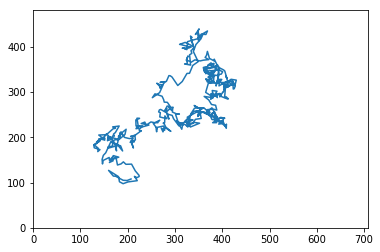

In [8]:
plt.plot(xx, yy)
plt.xlim([0, width])
plt.ylim([0, height])

In [9]:
def load_imgs(vidPath):
    '''
    Reads frames from video and stores as a list
    
    Parameters: 
    vidPath (string): Path to video
    
    Returns: 
    list of images
    '''
    
    cap = cv2.VideoCapture(vidPath)
    imgs = []
    for ff in range(length):
        ret, frame = cap.read()
        if np.mod(ff, 50) == 0:
            print(ff) # prints progress in 50 frames
        
        # convert to grey
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        imgs.append(img)
            
    cap.release()
    return imgs

In [10]:
imList = load_imgs(vidPath)

0
50
100
150
200
250
300
350
400
450


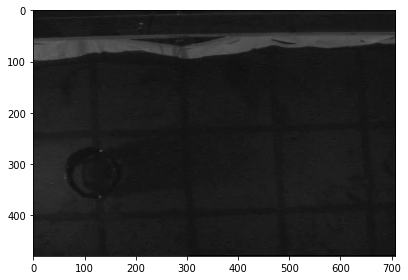

In [11]:
# add points to video
io.imshow(imList[0])

In [12]:
# add circles up to XX points in the past

lagPoints = 100 # number of points to plot on each frame
alphaVals = np.flip(np.linspace(0, 0.2, lagPoints), axis = 0)

outputImgs = []
for frameNum in np.arange(0, length):
    
    # adjust gamma
    im1 = adjust_gamma(imList[frameNum], 3)
    
    # convert to rgb, so I can add colored points
    image = cv2.cvtColor(im1,cv2.COLOR_GRAY2RGB)
    
    
    overlay = image.copy()
    output = image.copy()
    for jj in range(lagPoints):
        # add circle, centered at closest integer value
        cv2.circle(overlay, (int(dataPoints.x[np.max([frameNum-jj, 0])]), 
                             int(dataPoints.y[np.max([frameNum-jj, 0])])), 
                   3, (219, 189, 166), -1)
        cv2.addWeighted(overlay, alphaVals[jj], output, 1 - alphaVals[jj],0, output)
    outputImgs.append(output)
    if np.mod(frameNum, 50) == 0:
        print(frameNum)


0
50
100
150
200
250
300
350
400
450


In [13]:
# make directory to store images
tempImgDirectory = os.path.join(os.path.dirname(vidPath), "tmpImgs")
if not os.path.exists(tempImgDirectory):
    os.mkdir(tempImgDirectory)

# play new  video & save images
for ii in np.arange(1,len(outputImgs)):
    frame = outputImgs[ii]
    
    # Display the resulting frame 
    cv2.imshow('Frame', frame) 
    
    # save img
    cv2.imwrite(os.path.join(tempImgDirectory, str(ii).zfill(4) + ".png"), frame)
   

    # Press Q on keyboard to  exit 
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break
cv2.destroyAllWindows()

In [15]:
# # you can make images larger: 
# output = cv2.resize(output, (width*2, height*2), interpolation=cv2.INTER_CUBIC)

In [16]:
# show a single image
cv2.namedWindow('Output')
cv2.imshow("Output", output)

# # destroy the window when the mouse clicks the "X"
while cv2.getWindowProperty('Output', cv2.WND_PROP_VISIBLE) == 1:
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break
cv2.destroyAllWindows()

In [17]:
# convert images to video with ffmpeg
os.chdir(tempImgDirectory)
print(tempImgDirectory)
# use ffmpeg to convert directory to video
# -r is output frame rate
os.system('ffmpeg -start_number 0 -r 50 -i %04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -pix_fmt yuv420p -y outputVid.mp4')

In [23]:
# delete images from directory
delFiles = [f for f in os.listdir(tempImgDirectory) if f.endswith("png")]

In [27]:
dlfs = [os.remove(os.path.join(tempImgDirectory, delFiles[ii])) for ii in range(len(delFiles))]

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'D:\\Dropbox\\AcademiaDropbox\\dataAnalysisForOthers\\SujayFish\\tmpImgs\\0001.png'